In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_curve, auc)


In [6]:
# Importing dataset
df = pd.read_csv('15s_Data.csv')
df.head()

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1,VPN
0,14609555,14609555,14257477,41,53236,2822141,2823216,486985.166667,648067.136364,3.696211,...,6592862,6788103.0,6983344,276112.470129,1056123,1702460.0,2348797,914058.551263,VPN-FT,True
1,14997699,14976002,14976270,34,10,280324,318681,55672.869888,34036.977273,47.407272,...,-1,0.0,-1,0.000000,-1,0.0,-1,0.000000,STREAMING,False
2,14440454,14401292,14401395,959225,959133,960892,960909,960086.133333,960093.000000,2.215997,...,-1,0.0,-1,0.000000,-1,0.0,-1,0.000000,VPN-VOIP,True
3,14441610,14402929,14403020,959367,958939,960982,961896,960195.266667,960201.333333,2.215819,...,-1,0.0,-1,0.000000,-1,0.0,-1,0.000000,VPN-VOIP,True
4,14993539,14993539,14778375,152,7,272001,351381,105588.302817,16365.863787,69.830078,...,-1,0.0,-1,0.000000,-1,0.0,-1,0.000000,VPN-STREAMING,True


In [8]:
# Data Preprocessing

# Remove duplicate records 
df = df.drop_duplicates()
# Removing records with missing values
df = df.dropna()

# Removing the non-numeric 'class1' column.
features = df.drop(['class1', 'VPN'], axis=1)

# Convert VPN to numeric 0 and 1
target = df['VPN'].map({True: 1, False: 0})

# Normalizing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [ ]:
# Split data into training-testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, target, test_size=0.3, random_state=42, stratify=target
)

In [10]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

gbt = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gbt, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_gbt = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}


Cross Validation Scores: [0.92414066 0.91897233 0.92608696 0.92055336 0.9173913 ]
Average Accuracy: 92.14


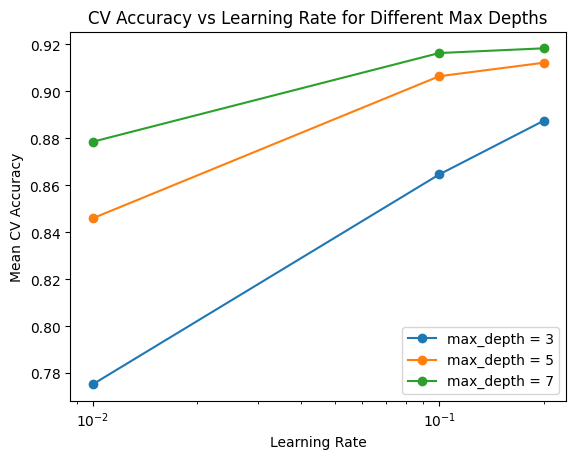

In [13]:
# Cross validation
scores = cross_val_score(best_gbt, X_train, y_train, cv=5, scoring='accuracy')
print("Cross Validation Scores:", scores)
average = scores.mean() * 100
print("Average Accuracy:", str(average)[:5])

# Plotting graph for every depth
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']
learning_rates = param_grid['learning_rate']

plt.figure()
for depth in param_grid['max_depth']:
    indices = [i for i, d in enumerate(results['param_max_depth']) if d == depth]
    # For each depth get score corresponding to each rate
    lr_scores = []
    for lr in learning_rates:
        idx = [i for i in indices if results['param_learning_rate'][i] == lr]
        # Average score for this combination of rate and depth.
        lr_scores.append(np.mean([mean_test_scores[i] for i in idx]))
    plt.plot(learning_rates, lr_scores, marker='o', label=f'max_depth = {depth}')
plt.xscale('log')
plt.title('CV Accuracy vs Learning Rate for Different Max Depths')
plt.xlabel('Learning Rate')
plt.ylabel('Mean CV Accuracy')
plt.legend()
plt.show()

Testing Accuracy: 92.60556887331735
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2609
           1       0.93      0.93      0.93      2814

    accuracy                           0.93      5423
   macro avg       0.93      0.93      0.93      5423
weighted avg       0.93      0.93      0.93      5423



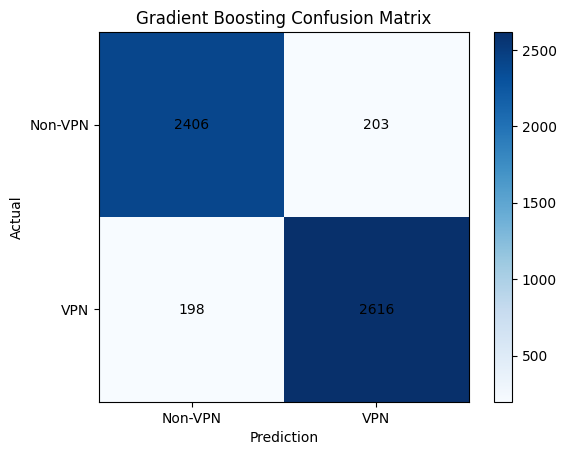

In [14]:
# Model Training and testing
best_gbt.fit(X_train, y_train)
y_pred = best_gbt.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Testing Accuracy:", accuracy * 100)
print(report)

# Plotting Confusion Matrix.
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title('Gradient Boosting Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.colorbar()
plt.xticks([0, 1], ['Non-VPN', 'VPN'])
plt.yticks([0, 1], ['Non-VPN', 'VPN'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="black")
plt.show()

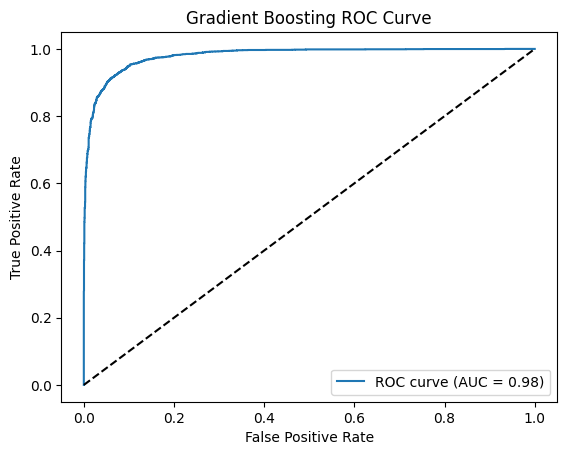

In [ ]:
# Plotting ROC Curve and calculating AUC

# Getting probability estimates for the positive class.
y_prob = best_gbt.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {str(roc_auc)[:4]})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Gradient Boosting ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()